In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import exp
import os, time

In [63]:
def getFilesFrom(baseDir):
    files = []
    
    for file in os.listdir(baseDir):
        if '.csv' not in file:
            continue

        filePath = os.path.join(baseDir, file) if baseDir else file
        files.append(filePath)

    return files


files = getFilesFrom('files')
files

['files\\test_1.csv',
 'files\\test_10.csv',
 'files\\test_11.csv',
 'files\\test_2.csv',
 'files\\test_3.csv',
 'files\\test_4.csv',
 'files\\test_5.csv',
 'files\\test_6.csv',
 'files\\test_7.csv',
 'files\\test_8.csv',
 'files\\test_9.csv']

In [64]:
df = pd.read_csv('DataBase.csv')
df

,time,pressure,ratio,blowing,start_blow,stop_blow
0,0.0,38.131700,-0.385811,False,False,False
1,0.1,38.106850,-0.311824,False,False,False
2,0.2,38.089020,-0.244672,False,False,False
3,0.3,38.077120,-0.185016,False,False,False
4,0.4,38.070100,-0.133121,False,False,False
...,...,...,...,...,...,...
11435,1142.5,7.631976,-0.014643,False,False,False
11436,1142.6,7.631740,-0.012551,False,False,False
11437,1142.7,7.631571,-0.010327,False,False,False
11438,1142.8,7.631416,-0.008653,False,False,False


# OBTENDO A VARIAVEL DESEJADA
Os valores de início e fim de sopro são os pontos discretizados ao longo do gráfico, o objetivo do modelo é encontrar o momento que iniciou o sopro, e o momento que não há mais sopro

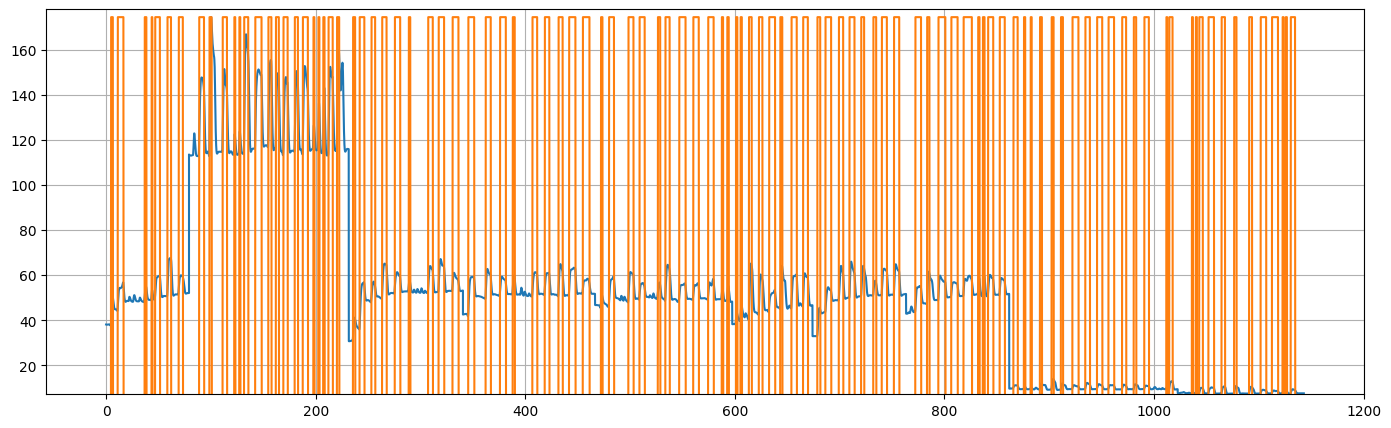

In [67]:
plt.figure(figsize=(17, 5))
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.blowing * df.pressure.max())
plt.ylim(df.pressure.min()*0.97, df.pressure.max()*1.02)
plt.grid()

In [68]:
startCount = (df.start_blow == True).sum() / len(df) * 100
stopCount  = (df.stop_blow == True).sum()  / len(df)  * 100
total = int((startCount + stopCount) * len(df) / 100)

print(f'{startCount:.2f}% dos dados inicio de sopro')
print(f'{stopCount:.2f}% dos dados término de sopro')
print(f'total: {startCount + stopCount:.2f}% ({total} dados)')

10.31% dos dados inicio de sopro
16.73% dos dados término de sopro
total: 27.05% (3094 dados)


# SEPARAÇÃO DOS DADOS
As funções abaixo são responsáveis para obter os dados de treino (a partir das suas $n$ entradas anteriores) e criar o modelo de regressão logística para os dados de treino e encontrar a precisão comparando com os dados de teste

In [69]:
def getStates(df, key, var='y', n=10):
    table = df.copy() 
    table[f'{var}n'] = table[key]

    for i in range(1, n):
        table[f'{var}n{i}'] = table[key].shift(i)

    table.fillna(0, inplace=True)
    columns = [f'{var}n'] + [f'{var}n{i}' for i in range(1, n)]
    return table[columns]


def getTrainData(df, size=5):
    return getStates(df, 'pressure', 'Y', size)


size  = 30
xData = getTrainData(df, size)
xData.head(10)

,Yn,Yn1,Yn2,Yn3,Yn4,Yn5,Yn6,Yn7,Yn8,Yn9,...,Yn20,Yn21,Yn22,Yn23,Yn24,Yn25,Yn26,Yn27,Yn28,Yn29
0,38.13170,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,38.10685,38.13170,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38.08902,38.10685,38.13170,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38.07712,38.08902,38.10685,38.13170,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.07010,38.07712,38.08902,38.10685,38.13170,0.00000,0.00000,0.00000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,38.06711,38.07010,38.07712,38.08902,38.10685,38.13170,0.00000,0.00000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,38.06701,38.06711,38.07010,38.07712,38.08902,38.10685,38.13170,0.00000,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,38.06861,38.06701,38.06711,38.07010,38.07712,38.08902,38.10685,38.13170,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,38.07127,38.06861,38.06701,38.06711,38.07010,38.07712,38.08902,38.10685,38.13170,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,38.07445,38.07127,38.06861,38.06701,38.06711,38.07010,38.07712,38.08902,38.10685,38.1317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
is_blowing = False

def isBlowing(startBlow, stopBlow):
    global is_blowing

    if startBlow:
        is_blowing = True

    if stopBlow:
        is_blowing = False

    return is_blowing

# MODELO LOGISTIC REGRESSION
As funções abaixo são responsáveis para obter os dados de treino (a partir das suas $n$ entradas anteriores) e criar o modelo de regressão logística para os dados de treino e encontrar a precisão comparando com os dados de teste

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import random

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [72]:
def getModel(xData, yData, trainSize=0.20):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=trainSize)
    model = LogisticRegression()
    model.fit(xTreino, yTreino)
    return model

def plotModel(yTest, yModel, yNames, title=''):
    confusionMatrix = confusion_matrix(yTest, yModel)
    score = accuracy_score(yTest, yModel)

    plt.figure(figsize=(10, 5))
    sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues", xticklabels=yNames, yticklabels=yNames)
    plt.xlabel('Predicted Label'), plt.ylabel('True Label')
    plt.title(f'Precisão do Modelo: {title} {score*100:.2f}%')
    plt.show()

In [73]:
def getBestModel(df, timeout=5):
    global is_blowing
    bestModel  = {'start': None, 'stop': None, 'score': 0.00}
    startTime  = time.time()
    xData = getTrainData(df, size)
    
    while time.time() - startTime < timeout:
        trainSize = random.uniform(0.54, 0.60)
        startBlowModel = getModel(xData, df.start_blow, trainSize)
        stopBlowModel  = getModel(xData, df.stop_blow, trainSize)

        yStart = startBlowModel.predict(xData)
        yStop  = stopBlowModel.predict(xData)

        is_blowing = False
        yBlow = [isBlowing(start, stop) for start, stop in zip(yStart, yStop)] 
        score = accuracy_score(df.blowing, yBlow)

        if score > bestModel['score']:
            print(f'score update: {score*100:.2f}% | train size: {trainSize:.2f}')
            bestModel = {'start': startBlowModel, 'stop': stopBlowModel, 'score': score}
        
        if score == 1.0:
            break
        
    return bestModel


model = getBestModel(df, timeout=30)
startBlowModel = model['start']
stopBlowModel  = model['stop']

score update: 84.13% | train size: 0.59
score update: 84.32% | train size: 0.60
score update: 85.45% | train size: 0.58
score update: 85.95% | train size: 0.56
score update: 86.89% | train size: 0.60


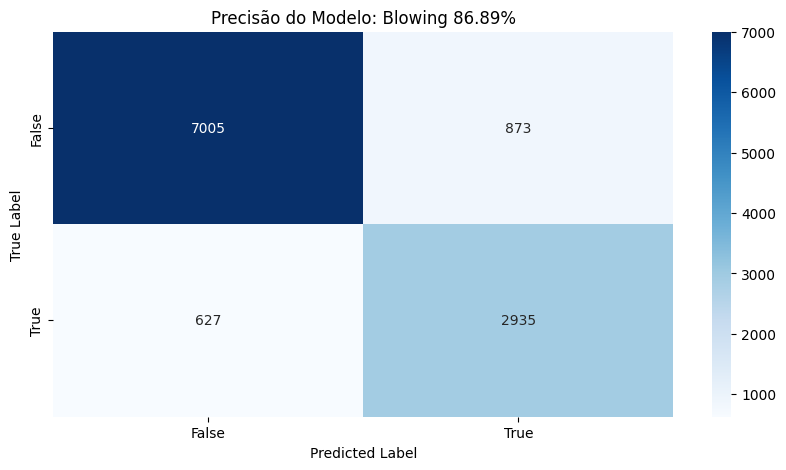

In [74]:
xData   = getTrainData(df, size)
classes = startBlowModel.classes_

df['start_blow_pred'] = startBlowModel.predict(xData)
df['stop_blow_pred']  = stopBlowModel.predict(xData)
df['prediction']      = df.apply(lambda row: isBlowing(row.start_blow_pred, row.stop_blow_pred), axis=1)
plotModel(df.prediction, df.blowing, classes, 'Blowing')

files\test_1.csv


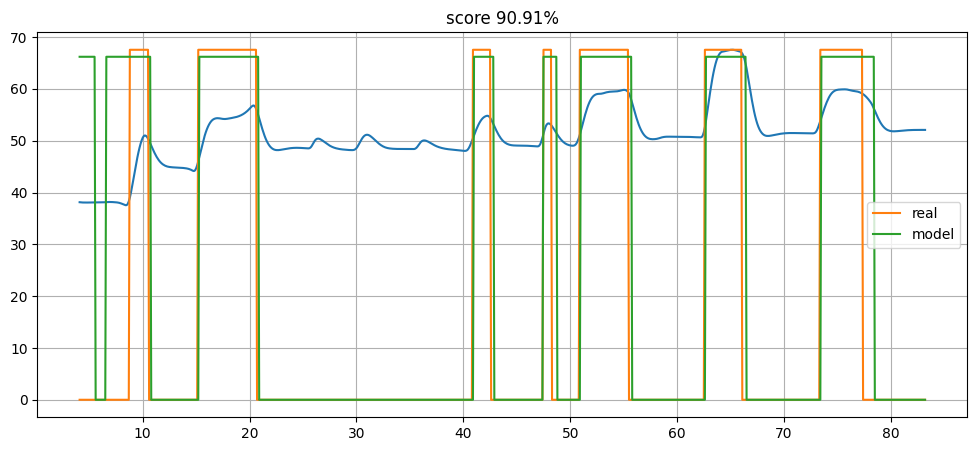

files\test_10.csv


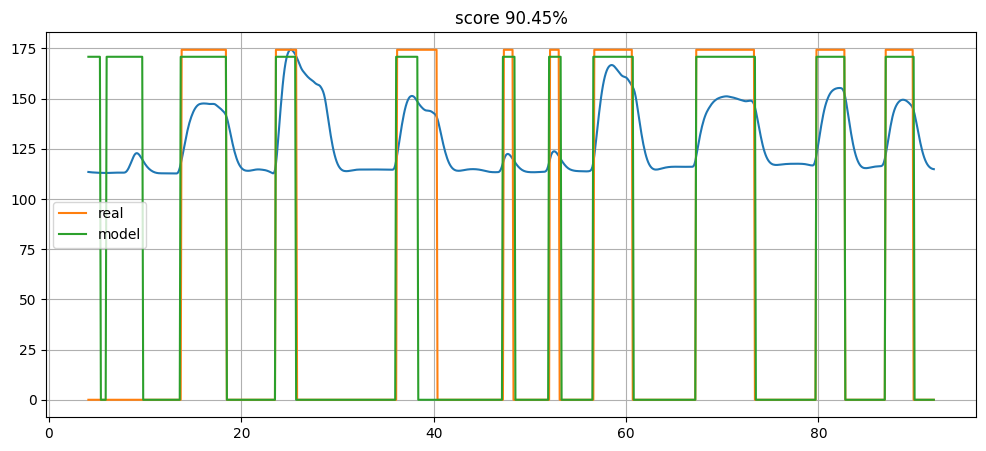

files\test_11.csv


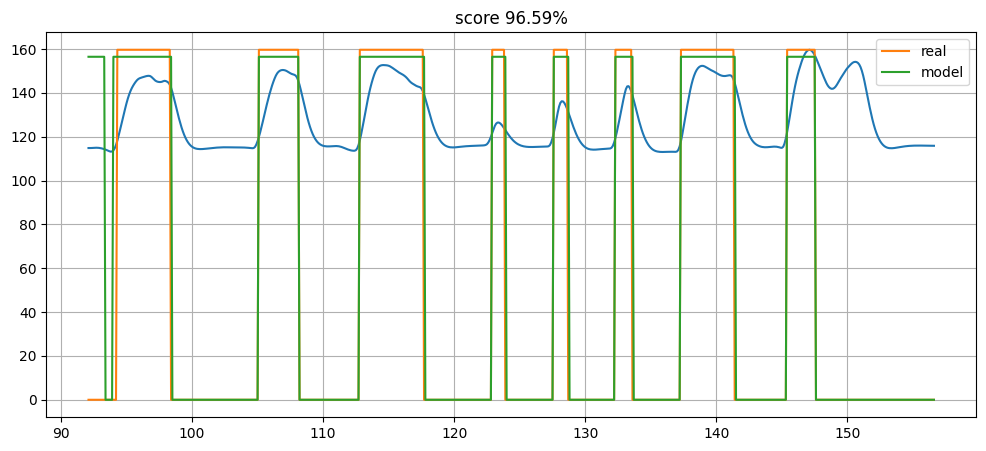

files\test_2.csv


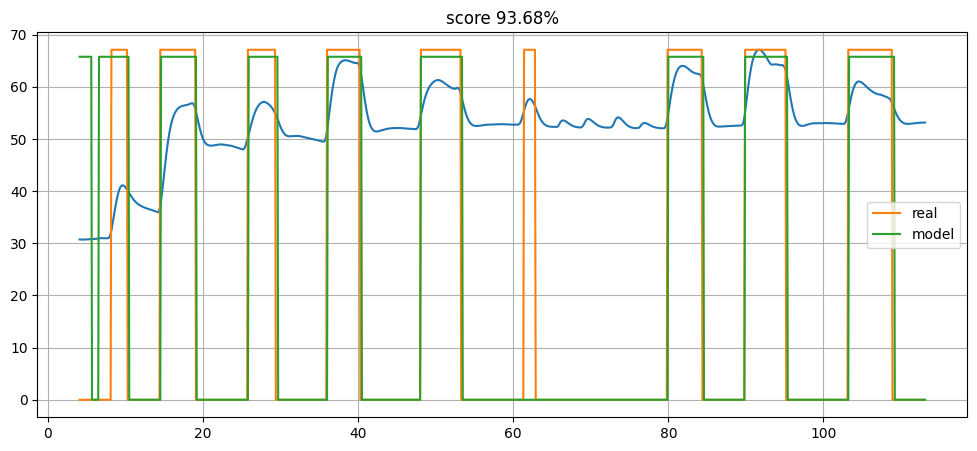

files\test_3.csv


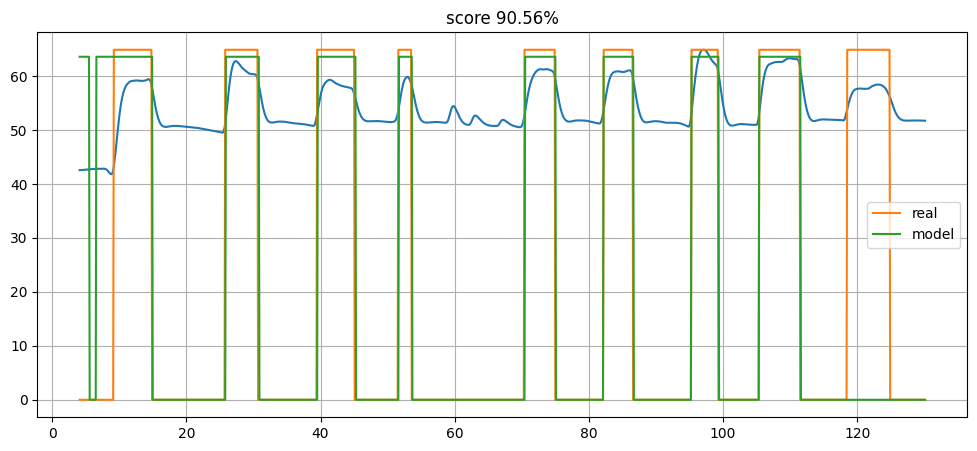

files\test_4.csv


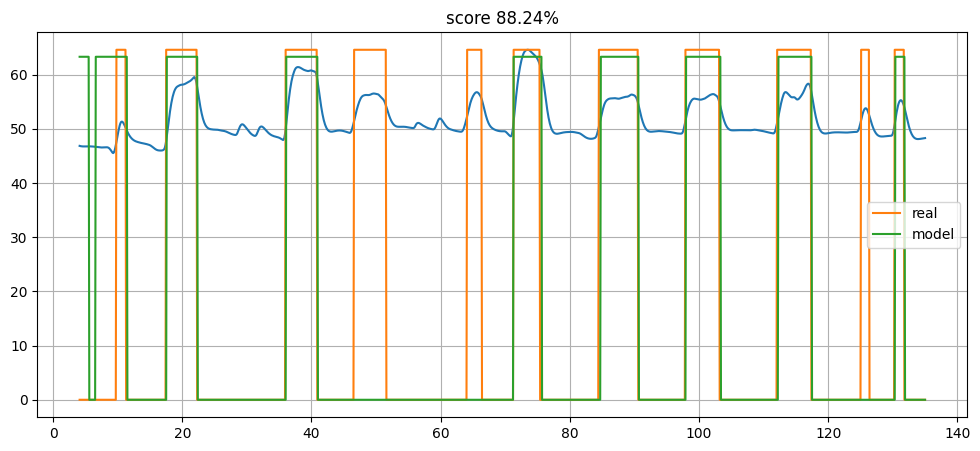

files\test_5.csv


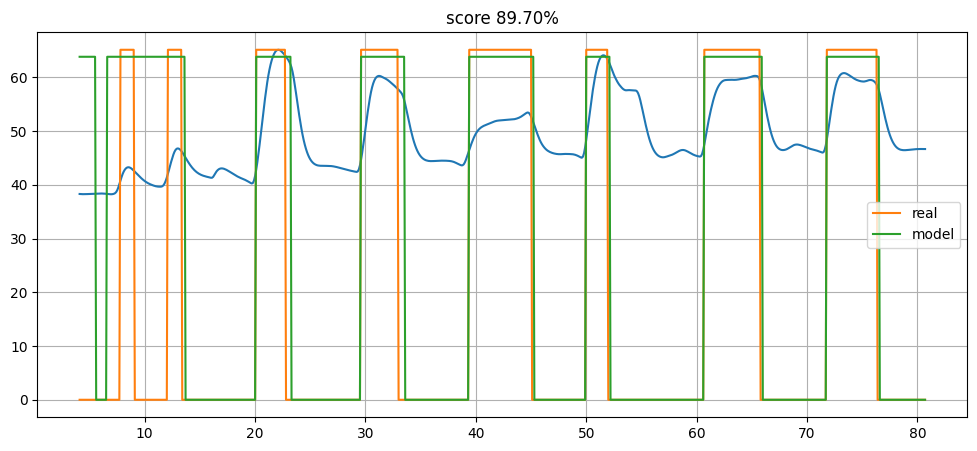

files\test_6.csv


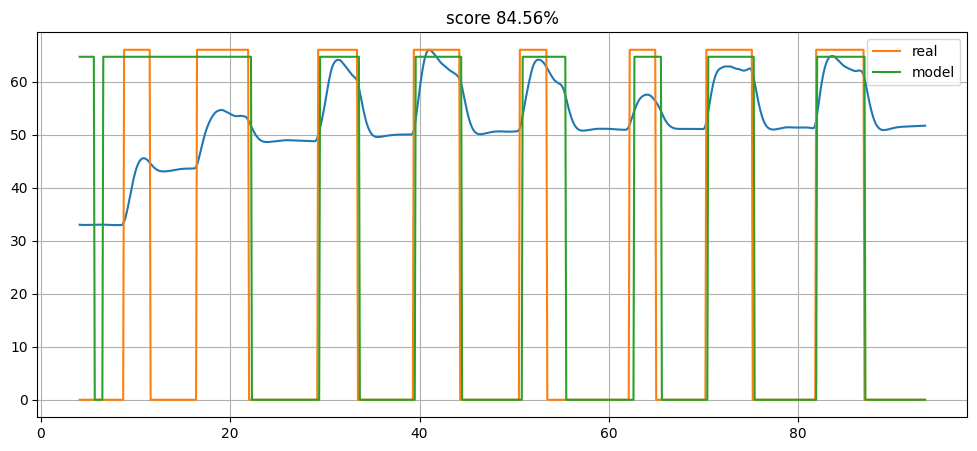

files\test_7.csv


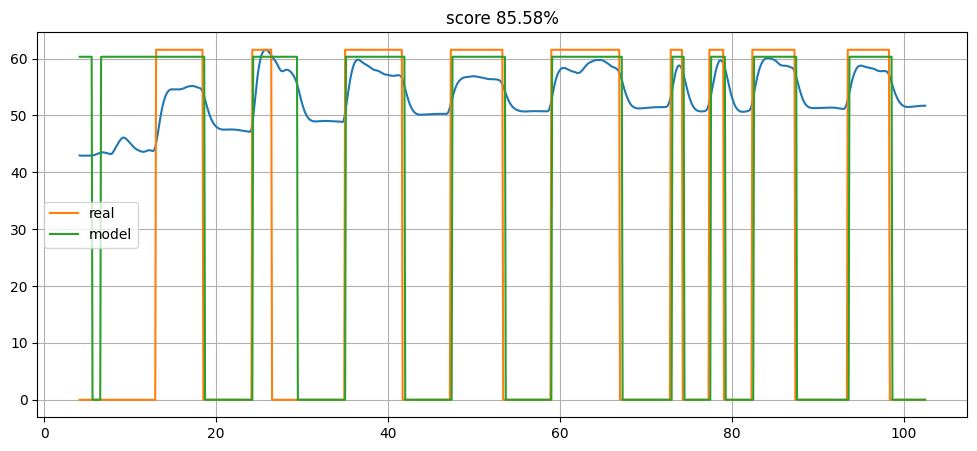

files\test_8.csv


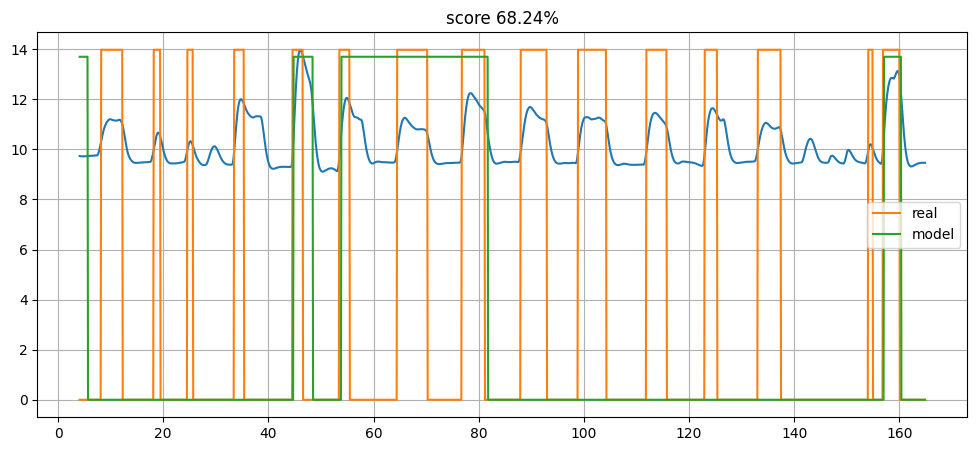

files\test_9.csv


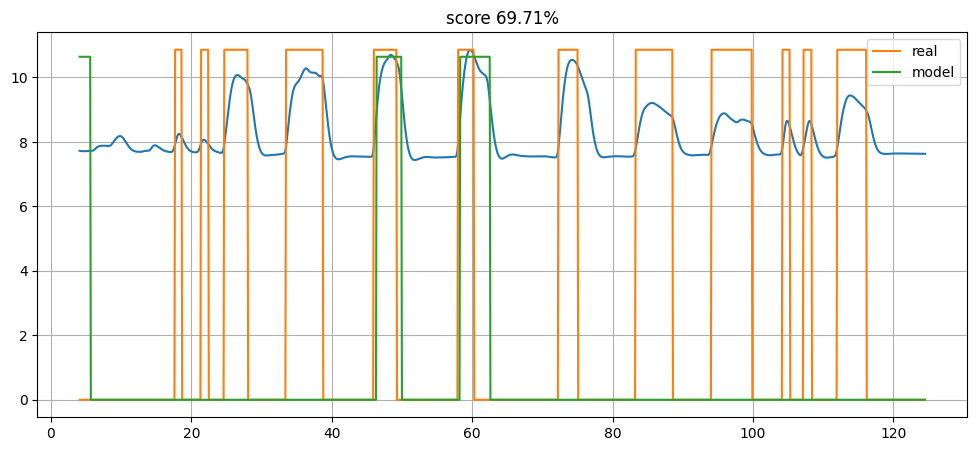

In [75]:
for filePath in files:
    df = pd.read_csv(filePath)
    xData = getTrainData(df, size)
    print(filePath)
    
    is_blowing = False
    df['start_blow_pred'] = startBlowModel.predict(xData)
    df['stop_blow_pred']  = stopBlowModel.predict(xData)
    df['prediction']      = df.apply(lambda row: isBlowing(row.start_blow_pred, row.stop_blow_pred), axis=1)
    score = accuracy_score(df.blowing, df.prediction)

    plt.figure(figsize=(12, 5))
    plt.plot(df.time, df.pressure)
    plt.plot(df.time, df.blowing * max(df.pressure), label='real')
    plt.plot(df.time, df.prediction * 0.98 * max(df.pressure), label='model')
    plt.legend(), plt.grid(), plt.title(f'score {score*100:.2f}%'), plt.show()

# IMPLEMENTANDO O MODELO
Para implementar digitalmente em um arduino, o modelo LogisticRegression obedece a seguinte fórmula:
$$p = \frac{1}{1 + e^{-(\omega_0 + \omega_1 x_1 + \omega_2 x_2 + ....)}}$$

In [76]:
def getModelString(model):
    coefs = model.coef_[0]
    intercept = model.intercept_[0]
    variables = model.feature_names_in_
    
    text = f'(1.0 / (1.0 + exp(-({intercept:.6f}'

    for i, column in enumerate(variables):
        text += f' + Yn{[i]}*({coefs[i]:6f})'
    
    return text + '))))'


startBlowModel

LogisticRegression()

In [77]:
startBlowString = getModelString(startBlowModel)
stopBlowString  = getModelString(stopBlowModel)

print(f'const float pBlow    = {startBlowString};')
print(f'const float pNotBlow = {stopBlowString};')
print()

const float pBlow    = (1.0 / (1.0 + exp(-(-1.715442 + Yn[0]*(1.868983) + Yn[1]*(0.513248) + Yn[2]*(-0.682489) + Yn[3]*(-0.073140) + Yn[4]*(-0.772598) + Yn[5]*(-0.635943) + Yn[6]*(-0.307827) + Yn[7]*(0.118042) + Yn[8]*(0.066183) + Yn[9]*(-0.158794) + Yn[10]*(0.001468) + Yn[11]*(0.003038) + Yn[12]*(-0.284162) + Yn[13]*(-0.018256) + Yn[14]*(0.295247) + Yn[15]*(0.043475) + Yn[16]*(0.055834) + Yn[17]*(-0.071384) + Yn[18]*(-0.101924) + Yn[19]*(0.158782) + Yn[20]*(-0.092284) + Yn[21]*(0.029581) + Yn[22]*(-0.022116) + Yn[23]*(0.017335) + Yn[24]*(0.062239) + Yn[25]*(0.107536) + Yn[26]*(-0.071509) + Yn[27]*(0.016836) + Yn[28]*(-0.051030) + Yn[29]*(-0.069957)))));
const float pNotBlow = (1.0 / (1.0 + exp(-(-1.096464 + Yn[0]*(-1.018749) + Yn[1]*(-0.941248) + Yn[2]*(-0.238763) + Yn[3]*(0.141782) + Yn[4]*(0.734544) + Yn[5]*(0.112470) + Yn[6]*(0.466179) + Yn[7]*(0.558249) + Yn[8]*(0.118284) + Yn[9]*(-0.139841) + Yn[10]*(0.135782) + Yn[11]*(0.031650) + Yn[12]*(-0.096446) + Yn[13]*(0.153913) + Yn[14]*

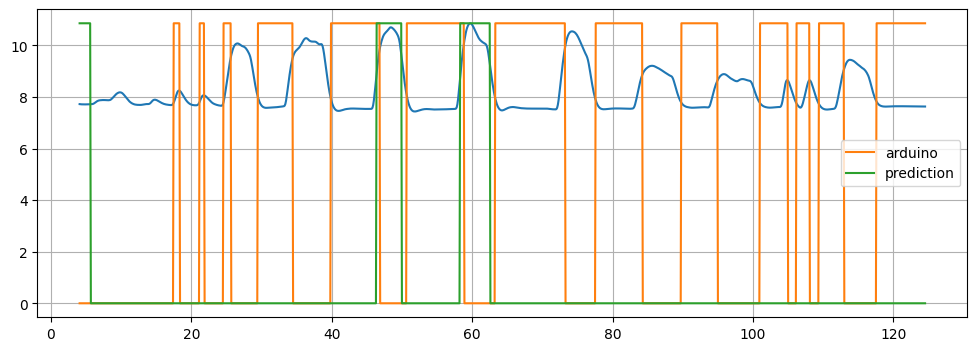

In [78]:
Yn = np.zeros(size)
is_blowing = False

def isBlowing(ratio):
    global size, Yn, is_blowing

    for n in range(size-1, 0, -1):
        Yn[n] = Yn[n-1]
    
    Yn[0] = ratio
    pBlow    = eval(startBlowString)
    pNotBlow = eval(stopBlowString)

    if pBlow > 0.5:
        is_blowing = True
    
    if pNotBlow > 0.5:
        is_blowing = False

    return is_blowing


df['arduino'] = df.ratio.apply(isBlowing)
plt.figure(figsize=(12, 4))
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.arduino    * df.pressure.max(), label='arduino')
plt.plot(df.time, df.prediction * df.pressure.max(), label='prediction')
plt.legend()
plt.grid()

files\test_1.csv


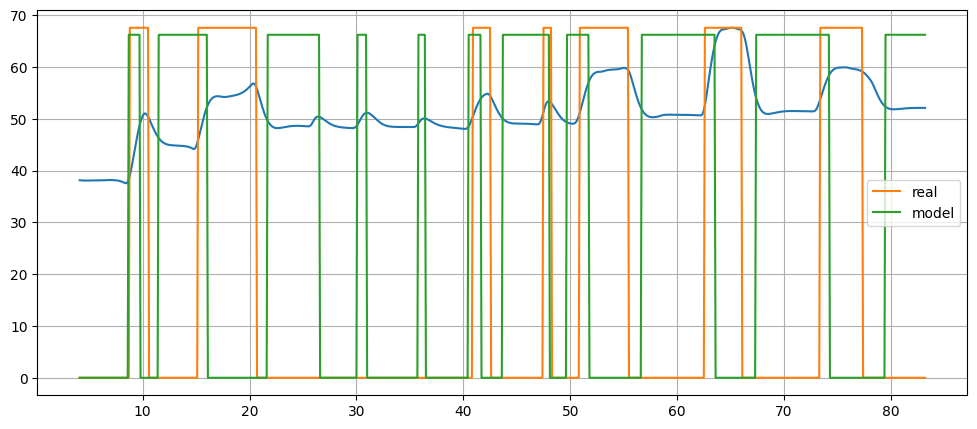

files\test_10.csv


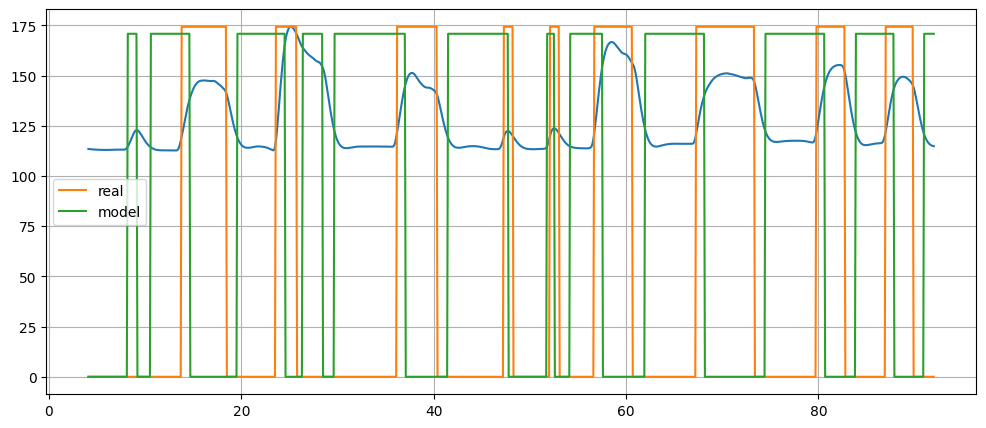

files\test_11.csv


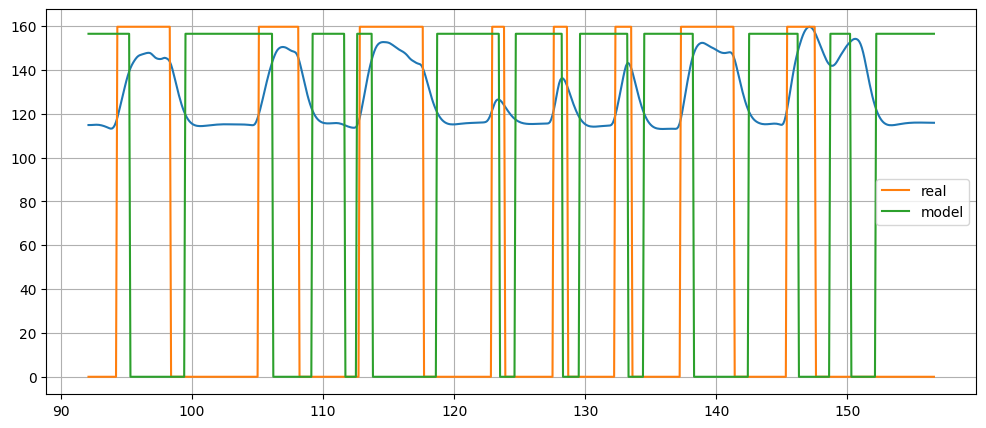

files\test_2.csv


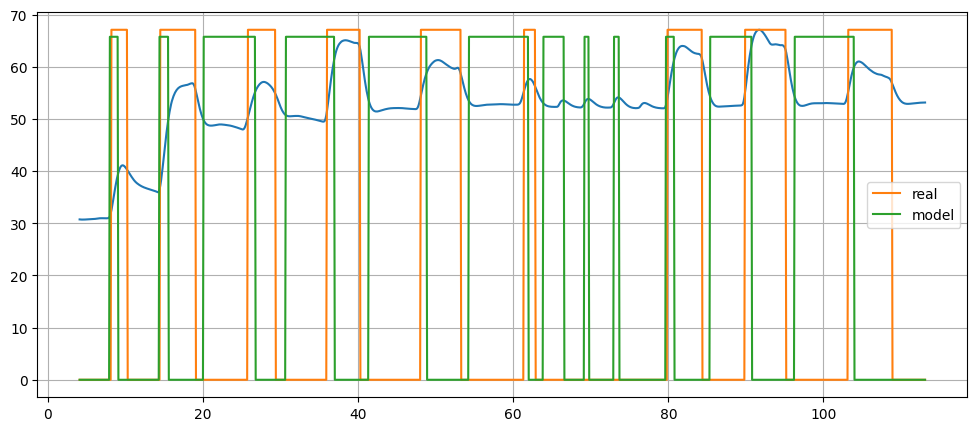

files\test_3.csv


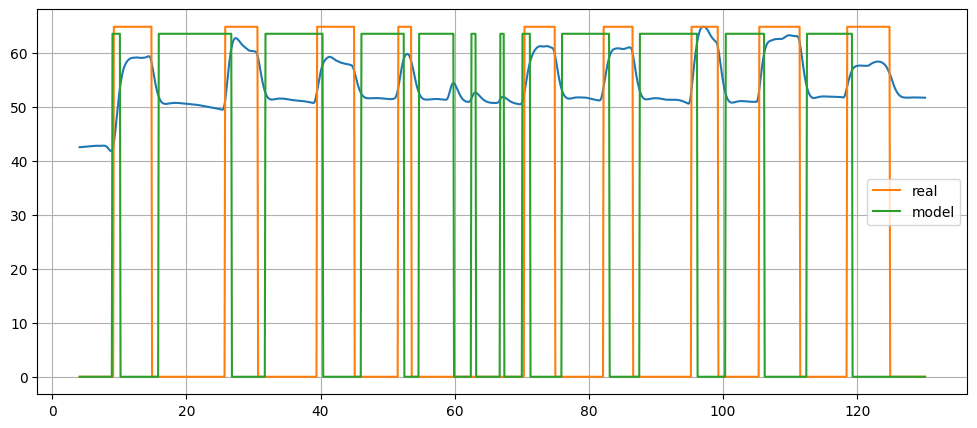

files\test_4.csv


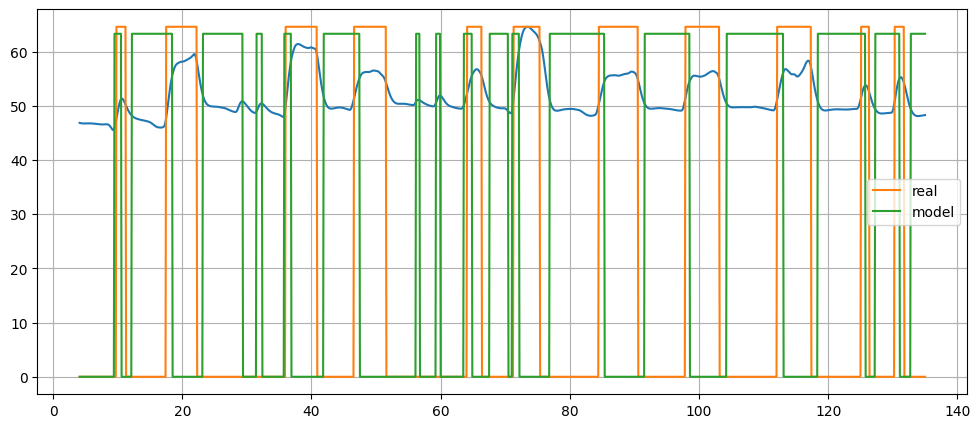

files\test_5.csv


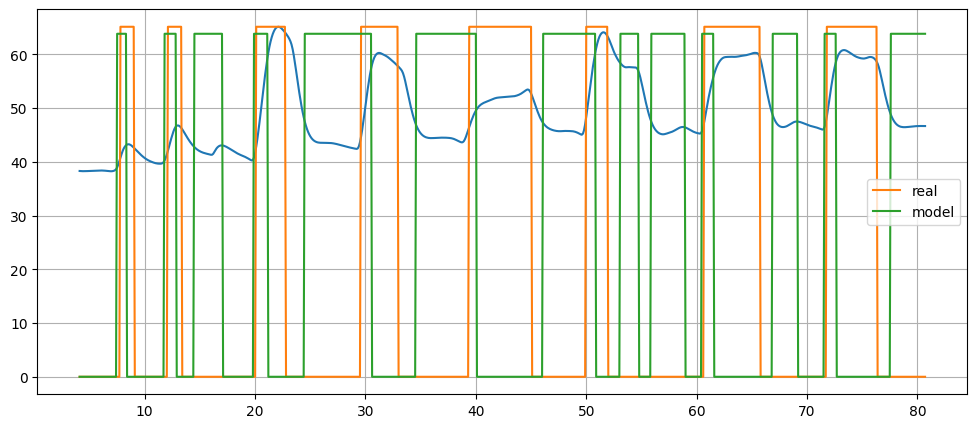

files\test_6.csv


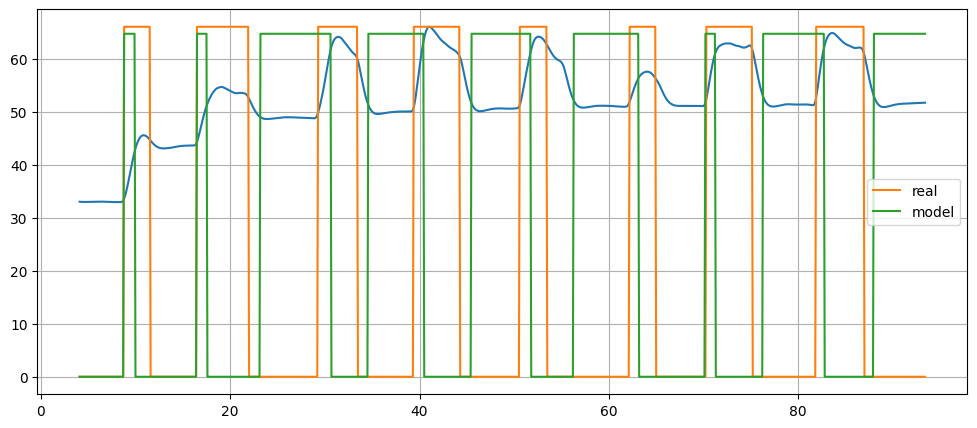

files\test_7.csv


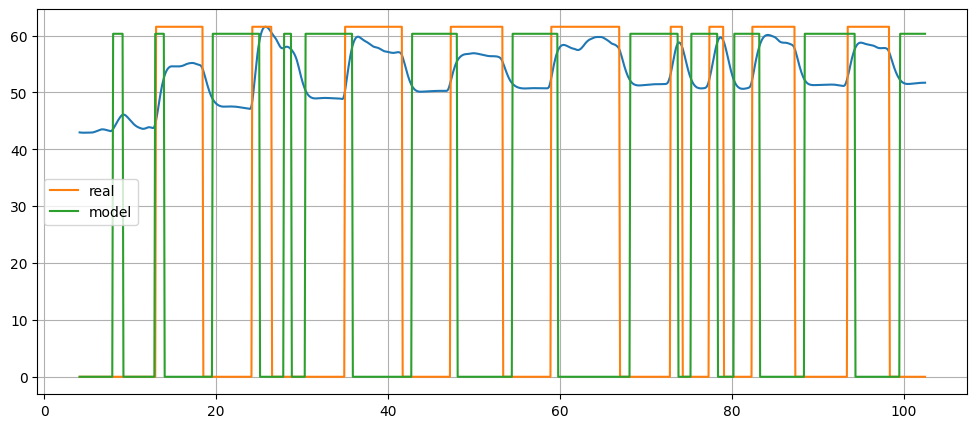

files\test_8.csv


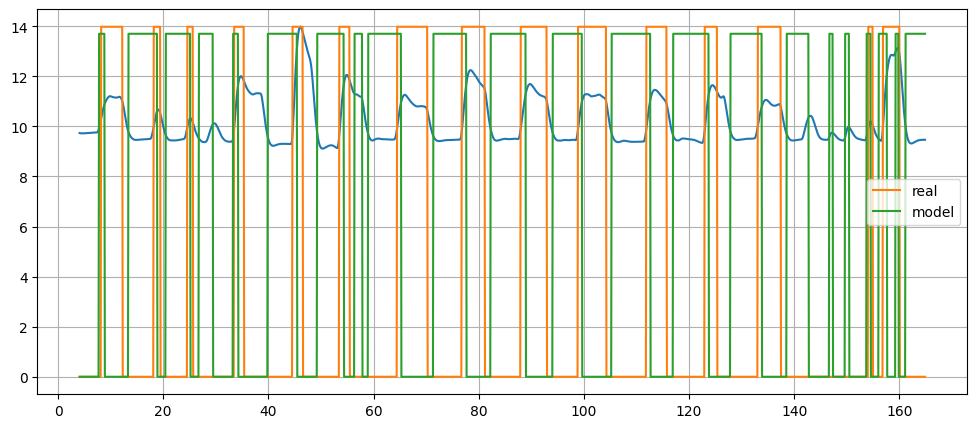

files\test_9.csv


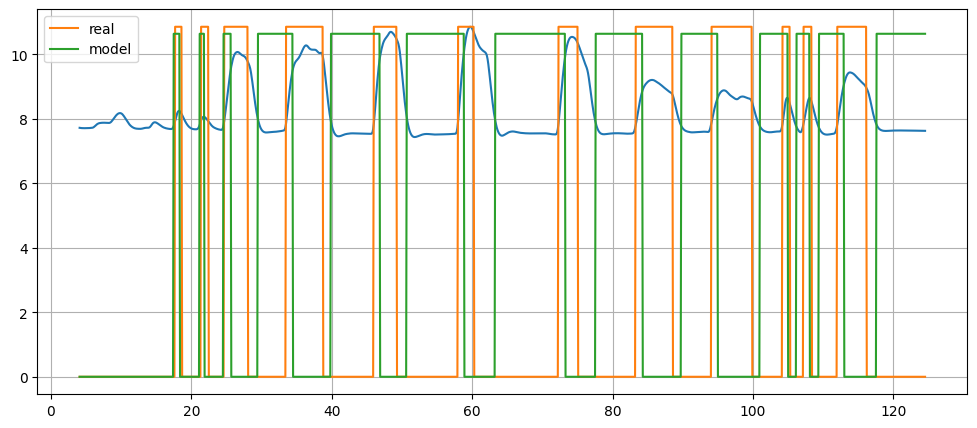

In [79]:
for filePath in files:
    df = pd.read_csv(filePath)
    print(filePath)
    is_blowing = False
    df['arduino'] = df.ratio.apply(isBlowing)
    plt.figure(figsize=(12, 5))
    plt.plot(df.time, df.pressure)
    plt.plot(df.time, df.blowing * max(df.pressure), label='real')
    plt.plot(df.time, df.arduino * 0.98 * max(df.pressure), label='model')
    plt.legend(), plt.grid(), plt.show()